# Power spectral density


author: steeve.laquitaine@epfl.ch

**Data description**  
**in-vivo**:

* `Marques` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 30.0kHz
    * 20.25 min
    * "Spontaneous activity" (Only anesthetized condition)
    
**in-silico**:

* `Neuropixels` (aligned with cortical column)
    * run: 2023_10_18
    * rat cortex S1
    * 384ch 
    * 40.0kHz
    * 10 min
    * "Spontaneous activity" (Only anesthetized condition)

**Method**

* PSD of 5 mins of recordings
* The quality of PSD estimation from FFT depends on a unique parameter, the number of signal samples, N. The largest the number of samples, 
and the better the frequency resolution, $f_r$, of the PSD, given sampling frequency $f_s$

$$f_r = f_s / N$$

* We estimated all PSDs over the same number of recording samples, to allow for a fair comparison of PSDs which frequency resolution depends on the signal's sample size. Small sample size degrades the frequency resolution of the PSD compared to large sample size, potentially masking significant features.
* To minimize computational cost, we show the PSDs estimated from the same sample sizes corresponding to about 5 min of recordings, which was the shortest period that best preserved the features observed in the PSD estimated from the entire recordings.
* We also estimated the PSD for all experiments' first 20 minutes (the largest common duration) and the entire recordings (see Supplementary figure).

### Setup

Activate `npx_10m_384ch_unit_classes` venv

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.extractors as se
import scipy
from scipy.optimize import minimize
import spikeinterface.full as si_full
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor
import scipy


# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.study import amplitude
from src.nodes.study import power

matplotlib.rcParams['agg.path.chunksize'] = 10000


# SETUP PARAMETERS
SFREQ_VIVO = 30000          # sampling frequency
SFREQ_SILICO = 40000        # sampling frequency


# SETUP DATASET COMFIG
# vivo
data_conf_vivo, param_conf_h_vivo = get_config("vivo_marques", "c26").values()
RAW_PATH_vivo = data_conf_vivo["probe_wiring"]["output"]
PREP_PATH_vivo = data_conf_vivo["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_vivo = data_conf_vivo["postprocessing"]["trace_snr"]
POWER_RAW_vivo = data_conf_vivo["analyses"]["traces"]["power"]["raw"]
POWER_PREP_vivo = data_conf_vivo["analyses"]["traces"]["power"]["preprocessed"]


# silico
data_conf_sili, param_conf_sili = get_config(
    "silico_neuropixels", "concatenated"
).values()
RAW_PATH_sili = data_conf_sili["probe_wiring"]["output"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_sili = data_conf_sili["postprocessing"]["trace_snr"]
POWER_RAW_sili = data_conf_sili["analyses"]["traces"]["power"]["raw"]
POWER_PREP_sili = data_conf_sili["analyses"]["traces"]["power"]["preprocessed"]


# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
FIG_SIZE = (8, 3)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 30
plt.rcParams['lines.linewidth'] = 1.1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 6
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14
plt.rcParams['ytick.major.width'] = 1
N_MAJOR_TICKS = 3
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent":True}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

2024-04-24 15:56:52,835 - root - utils.py - get_config - INFO - Reading experiment config.
2024-04-24 15:56:52,915 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-04-24 15:56:52,916 - root - utils.py - get_config - INFO - Reading experiment config.
2024-04-24 15:56:52,953 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Load Recordings

In [2]:
# load raw traces
RawVivo = si.load_extractor(RAW_PATH_vivo)
RawSili = si.load_extractor(RAW_PATH_sili)

# load preprocessed traces
PreprocessedVivo = si.load_extractor(PREP_PATH_vivo)
PreprocessedSili = si.load_extractor(PREP_PATH_sili)

### Keep sites in cortex

In [3]:
# takes 17 min

# Keep traces from good sites (in cortex)

# silico
layers = ["L1", "L2_3", "L4", "L5", "L6"]
site_layers_sili = RawSili.get_property("layers")
site_layers_sili = [
    "L2_3" if l_i == "L2" or l_i == "L3" else l_i for l_i in site_layers_sili
]
IN_CTX = np.isin(site_layers_sili, layers)
sites_sili = np.where(IN_CTX)[0]

# vivo
site_layers_vivo = RawVivo.get_property("layers")
IN_CTX = np.isin(site_layers_vivo, layers)
sites_vivo = np.where(IN_CTX)[0]


# Keep only raw traces from sites in cortex
raw_traces_sili = RawSili.get_traces()
raw_traces_vivo = RawVivo.get_traces()

raw_traces_sili = raw_traces_sili[:, sites_sili]
raw_traces_vivo = raw_traces_vivo[:, sites_vivo]

# Keep only preprocessed traces from sites in cortex
prep_traces_sili = PreprocessedSili.get_traces()
prep_traces_vivo = PreprocessedVivo.get_traces()

prep_traces_sili = prep_traces_sili[:, sites_sili]
prep_traces_vivo = prep_traces_vivo[:, sites_vivo]

In [ ]:
# keep only the layers
site_layers_sili = np.array(site_layers_sili)[sites_sili]
site_layers_vivo = np.array(site_layers_vivo)[sites_vivo]

In [11]:
60 * 40000

2400000

### Compute powers

In [ ]:
def get_site_power_marques_silico(trace, site):
    """calculate the power spectrum of the input trace

    Args:
        traces (np.ndarray): timepoints x sites voltage trace
        sfreq (_type_): voltage trace sampling frequency
        site: silent, automatically generated by ProcessPoolExecutor()

    Returns:
        _type_: _description_
    """
    (freq, power) = scipy.signal.periodogram(trace, SFREQ_SILICO, scaling="density")
    return np.array(power), np.array(freq)


def get_site_power_marques_vivo(trace, site):
    """calculate the power spectrum of the input trace

    Args:
        traces (np.ndarray): timepoints x sites voltage trace
        sfreq (_type_): voltage trace sampling frequency
        site: silent, automatically generated by ProcessPoolExecutor()

    Returns:
        _type_: _description_
    """
    (freq, power) = scipy.signal.periodogram(trace, SFREQ_VIVO, scaling="density")
    return np.array(power), np.array(freq)


def get_power_marques_silico_parallelized(traces: np.ndarray):
    """compute power spectrum density for Marques Silico
    using parallel computing

    Args:
        traces (np.ndarray): timepoints x sites voltage traces

    Returns:
        dict: frequencies x sites powers arraay and frequencies array
    """
    # takes 2 min (instead of 70 min w/o multiprocessing)
    nsites = traces.shape[1]

    # compute power for each site trace
    # in parallel with a pool of workers
    with ProcessPoolExecutor() as executor:
        power_by_site = executor.map(
            get_site_power_marques_silico,
            traces.T,
            np.arange(0, nsites, 1),
        )
    power_by_sites = list(power_by_site)

    # make an array with powers
    powersd = []
    for site in range(nsites):
        powersd.append(power_by_sites[site][0])
    powers = np.array(powersd)

    # store frequency domain
    freqs = power_by_sites[0][1]
    return {"power": powers, "freq": freqs}


def get_power_marques_vivo_parallelized(traces: np.ndarray):
    """compute power spectrum density for Marques Silico
    using parallel computing

    Args:
        traces (np.ndarray): timepoints x sites voltage traces

    Returns:
        dict: frequencies x sites powers arraay and frequencies array
    """
    # takes 2 min (instead of 70 min w/o multiprocessing)
    nsites = traces.shape[1]

    # compute power for each site trace
    # in parallel with a pool of workers
    with ProcessPoolExecutor() as executor:
        power_by_site = executor.map(
            get_site_power_marques_vivo,
            traces.T,
            np.arange(0, nsites, 1),
        )
    power_by_sites = list(power_by_site)

    # make an array with powers
    powersd = []
    for site in range(nsites):
        powersd.append(power_by_sites[site][0])
    powers = np.array(powersd)

    # store frequency domain
    freqs = power_by_sites[0][1]
    return {"power": powers, "freq": freqs}

In [ ]:
# takes 32 min

# compute raw powers
out_raw_sili = get_power_marques_silico_parallelized(raw_traces_sili)
out_raw_vivo = get_power_marques_vivo_parallelized(raw_traces_vivo)

# compute preprocessed powers
out_prep_sili = get_power_marques_silico_parallelized(prep_traces_sili)
out_prep_vivo = get_power_marques_vivo_parallelized(prep_traces_vivo)

### Plot

Site-averaged power spectrum is normalized (divided by its average over frequencies)

In [64]:
# takes 11 secs
psd_mean_raw_vivo = np.mean(out_raw_vivo["power"], axis=0)
psd_mean_raw_sili = np.mean(out_raw_sili["power"], axis=0)
psd_mean_prep_vivo = np.mean(out_prep_vivo["power"], axis=0)
psd_mean_prep_sili = np.mean(out_prep_sili["power"], axis=0)

/tmp/ipykernel_169961/4005417808.py:85: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout(**tight_layout_cfg)
/tmp/ipykernel_169961/4005417808.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("figures/2_realism/4_power/pdf/marques/marques_powers.pdf", **savefig_cfg)
/tmp/ipykernel_169961/4005417808.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("figures/2_realism/4_power/pdf/marques/marques_powers.pdf", **savefig_cfg)
/tmp/ipykernel_169961/4005417808.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("figures/2_realism/4_power/svg/marques/marques_powers.svg", **savefig_cfg)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc=

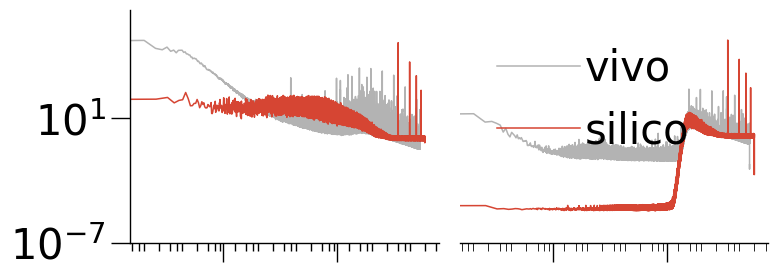

In [131]:
# takes 2 mins

fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

# Raw panel (8 secs) --------------------------------

# VIVO
# 3 secs
# psd_mean = np.mean(out_raw_vivo["power"], axis=0)
axes[0].plot(
    out_raw_vivo["freq"],
    psd_mean_raw_vivo / psd_mean_raw_vivo.mean(),
    color=COLOR_VIVO,
    label="vivo",
)

# SILICO
# psd_mean = np.mean(out_raw_sili["power"], axis=0)
axes[0].plot(
    out_raw_sili["freq"],
    psd_mean_raw_sili / np.mean(psd_mean_raw_sili),
    color=COLOR_SILI,
    label="silico",
)

# legend
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].spines[["right", "top"]].set_visible(False)
axes[0].set_ylim(YLIM)

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
)
axes[0].tick_params(which="both")
axes[0].xaxis.set_major_locator(locmaj)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
axes[0].set_xticklabels([])

# Preprocessed panel --------------------------------

# VIVO
# psd_mean = np.mean(out_prep_vivo["power"], axis=0)
axes[1].plot(
    out_prep_vivo["freq"],
    psd_mean_prep_vivo / np.mean(psd_mean_prep_vivo),
    color=COLOR_VIVO,
    label="vivo",
)

# SILICO
# psd_mean = np.mean(out_prep_sili["power"], axis=0)
axes[1].plot(
    out_prep_sili["freq"],
    psd_mean_prep_sili / np.mean(psd_mean_prep_sili),
    color=COLOR_SILI,
    label="silico",
)

# legend
axes[1].set_yscale("log")
axes[1].set_xscale("log")
axes[1].spines[["left", "right", "top"]].set_visible(False)
axes[1].legend(**legend_cfg)

# show x minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
)
axes[1].tick_params(which="both")
axes[1].xaxis.set_major_locator(locmaj)
axes[1].xaxis.set_minor_locator(locmin)
axes[1].xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# show y minor ticks
axes[1].set_yticks([])
axes[1].set_yticklabels([])
axes[1].set_ylim(YLIM)

fig.tight_layout(**tight_layout_cfg)

# save figures
plt.savefig(
    "figures/2_realism/4_power/pdf/marques/marques_concat_powers.pdf", **savefig_cfg
)
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_concat_powers.svg", **savefig_cfg
)

### Plot layer-wise

In [121]:
def plot_power_for_layer(
    layer: str,
    site_layers_sili: list,
    site_layers_vivo: list,
    out_raw_vivo: dict,
    out_raw_sili: dict,
):
    """plot power spectrum density for the
    specified layer

    Args:
        layer (str): layer "L1", "L2_3", "L4", "L5", "L6"
        site_layers_sili (list): layers of each in silico sites
        site_layers_vivo (list): layers of each in vivo sites
        out_raw_vivo (dict): _description_
        out_raw_sili (dict): _description_
    """

    fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

    # Select traces in layer

    # raw
    raw_power_sili_layer_i = out_raw_sili["power"][site_layers_sili == layer, :]
    raw_power_vivo_layer_i = out_raw_vivo["power"][site_layers_vivo == layer, :]

    # preprocessed
    prep_power_sili_layer_i = out_prep_sili["power"][site_layers_sili == layer, :]
    prep_power_vivo_layer_i = out_prep_vivo["power"][site_layers_vivo == layer, :]

    # Raw panel --------------------------------

    # VIVO
    psd_mean = np.mean(raw_power_vivo_layer_i, axis=0)
    axes[0].plot(
        out_raw_vivo["freq"],
        psd_mean / psd_mean.mean(),
        color=COLOR_VIVO,
        label="vivo",
    )

    # SILICO
    psd_mean = np.mean(raw_power_sili_layer_i, axis=0)
    axes[0].plot(
        out_raw_sili["freq"],
        psd_mean / np.mean(psd_mean),
        color=COLOR_SILI,
        label="silico",
    )

    # legend
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_xlabel("")
    # axes[0].set_ylabel("Power (ratio)")
    axes[0].set_yscale("log")
    axes[0].set_xscale("log")
    axes[0].spines[["right", "top"]].set_visible(False)
    # axes[0].set_xticklabels([])
    axes[0].set_ylim(YLIM)

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
    )
    axes[0].tick_params(which="both", width=1)
    axes[0].xaxis.set_major_locator(locmaj)
    axes[0].xaxis.set_minor_locator(locmin)
    axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # Preprocessed panel --------------------------------

    # VIVO
    psd_mean = np.mean(prep_power_vivo_layer_i, axis=0)
    axes[1].plot(
        out_prep_vivo["freq"],
        psd_mean / np.mean(psd_mean),
        color=COLOR_VIVO,
        label="vivo",
    )

    # SILICO
    psd_mean = np.mean(prep_power_sili_layer_i, axis=0)
    axes[1].plot(
        out_prep_sili["freq"],
        psd_mean / np.mean(psd_mean),
        color=COLOR_SILI,
        label="silico",
    )

    # legend
    # axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_xlabel("")
    axes[1].set_yscale("log")
    axes[1].set_xscale("log")
    axes[1].spines[["left", "right", "top"]].set_visible(False)
    # axes[1].set_xticklabels([])
    axes[1].set_yticklabels([])
    axes[1].set_yticks([])
    axes[1].set_xticks([])
    # axes[1].legend(**legend_cfg)
    axes[1].set_ylim(YLIM)

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
    )
    axes[1].tick_params(which="both", width=1)
    axes[1].xaxis.set_major_locator(locmaj)
    axes[1].xaxis.set_minor_locator(locmin)
    axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    fig.tight_layout(**tight_layout_cfg)
    return axes

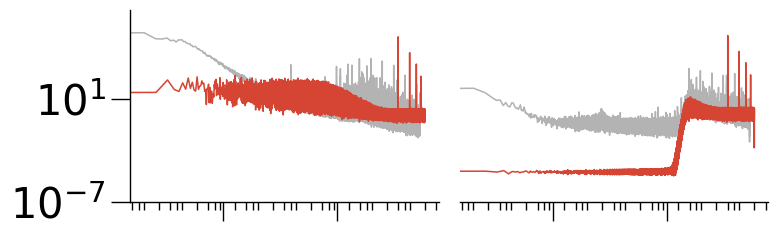

In [125]:
# takes 50 secs
axes = plot_power_for_layer(
    "L1", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

plt.savefig(
    "figures/2_realism/4_power/pdf/marques/marques_concat_power_layer1.pdf",
    **savefig_cfg
)
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_concat_power_layer1.svg",
    **savefig_cfg
)

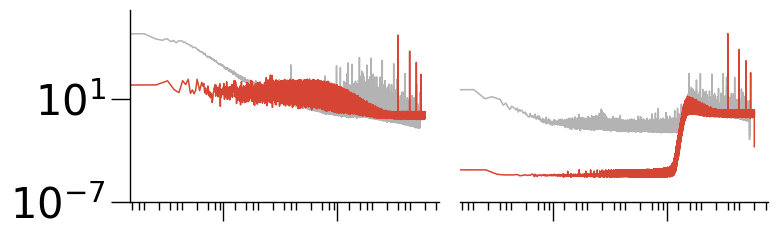

In [126]:
# takes 50 secs
axes = plot_power_for_layer(
    "L2_3", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

plt.savefig(
    "figures/2_realism/4_power/pdf/marques/marques_concat_power_layer2_3.pdf",
    **savefig_cfg
)
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_concat_power_layer2_3.svg",
    **savefig_cfg
)

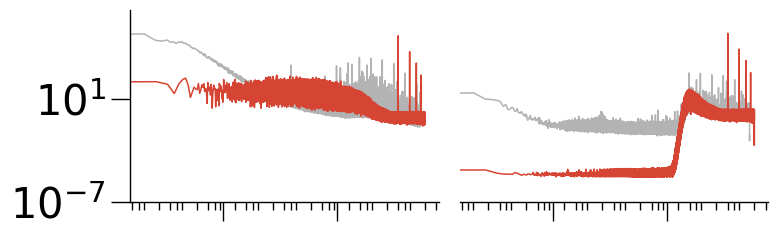

In [127]:
# takes 50 secs
axes = plot_power_for_layer(
    "L4", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
plt.savefig(
    "figures/2_realism/4_power/pdf/marques/marques_concat_power_layer4.pdf",
    **savefig_cfg
)
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_concat_power_layer4.svg",
    **savefig_cfg
)

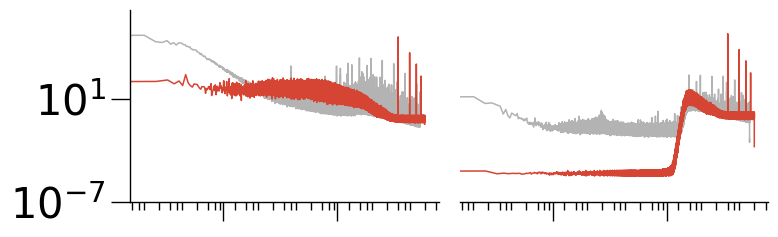

In [128]:
# takes 50 secs
axes = plot_power_for_layer(
    "L5", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

plt.savefig(
    "figures/2_realism/4_power/pdf/marques/marques_concat_power_layer5.pdf",
    **savefig_cfg
)
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_concat_power_layer5.svg",
    **savefig_cfg
)

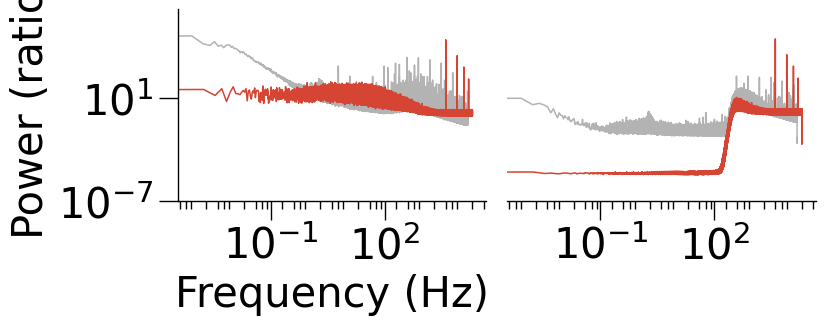

In [129]:
# takes 50 secs
axes = plot_power_for_layer(
    "L6", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_ylabel("Power (ratio)")
axes[0].set_xlabel("Frequency (Hz)")

plt.savefig(
    "figures/2_realism/4_power/pdf/marques/marques_concat_power_layer6.pdf",
    **savefig_cfg
)
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_concat_power_layer6.svg",
    **savefig_cfg
)

# references

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
